In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler

In [161]:
price_data = fdr.DataReader('005930')[['Close']]
mm = MinMaxScaler()
price_data = pd.DataFrame(mm.fit_transform(price_data), index=price_data.index)

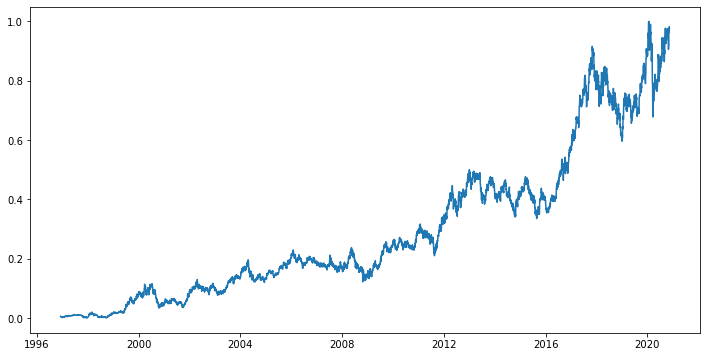

In [162]:
plt.figure(figsize=(12, 6))
plt.plot(price_data)

In [163]:
def split_data(stock_price, lookback):
    data_raw = stock_price.to_numpy()
    data = []
    
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index:(index+lookback)])
        
    data = np.array(data)
    
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]
    
    return x_train, y_train, x_test, y_test

In [164]:
x_train, y_train, x_test, y_test = split_data(price_data, 20)

In [165]:
x_train, y_train, x_test, y_test = torch.FloatTensor(x_train), torch.FloatTensor(y_train), torch.FloatTensor(x_test), torch.FloatTensor(y_test)

In [166]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [167]:
x_train.shape

torch.Size([4784, 19, 1])

In [179]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        
        return out
    
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        

In [180]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [181]:
loss_ls = []
for i in range(num_epochs):
    optimizer.zero_grad()
    
    prediction = model(x_train)
    
    loss = criterion(prediction, y_train)
    
    loss.backward()
    
    optimizer.step()
    
    loss_ls.append(loss)

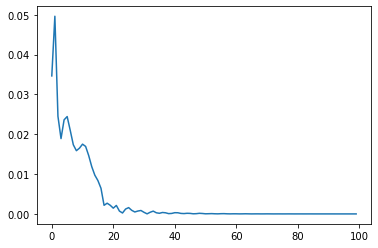

In [182]:
plt.plot(loss_ls)

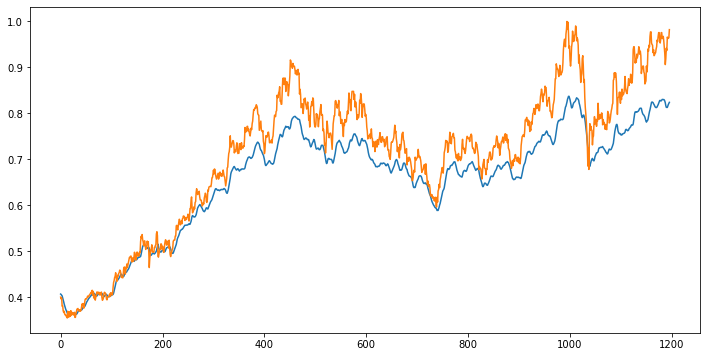

In [183]:
plt.figure(figsize=(12, 6))
plt.plot(model(x_test).detach().numpy())
plt.plot(y_test.detach().numpy())